In [1]:
#load the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import os
import tensorflow as tf
import keras
import cv2

#load libraries for data preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.layers import *
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.utils import plot_model



In [2]:
# define a  function to caculate the number of each emotion classes
train_dir = 'C:/Users/kowsh/Downloads/images/train/'
test_dir = 'C:/Users/kowsh/Downloads/images/validation/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [3]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7164,1825
neutral,4982,1216
sad,4938,1139
fear,4103,1018
angry,3993,960
surprise,3205,797
disgust,436,111


**Explanation:** The data set is unbalanced

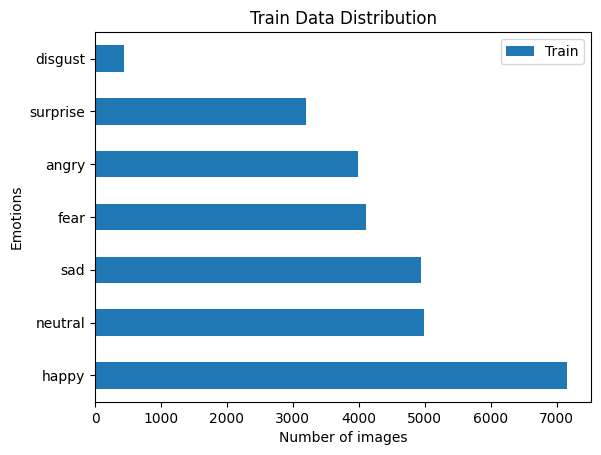

In [4]:
Train_Count.plot(kind='barh')
Test_Count.plot(kind='barh')
plt.title('Train Data Distribution')
plt.xlabel('Number of images')
plt.ylabel('Emotions')
plt.show()

**Explanation:** The number of happy faces is about 20 times tha disgust faces in training data set.

<Axes: >

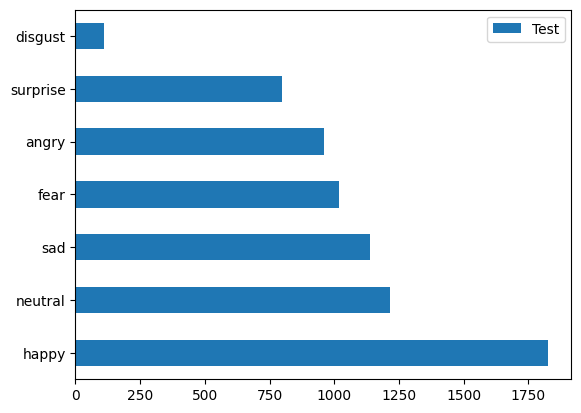

In [5]:
Test_Count.plot(kind='barh')

**Explanation:** The number of happy faces is about 17 times tha disgust faces in test data set.

### **Show a batch of images**

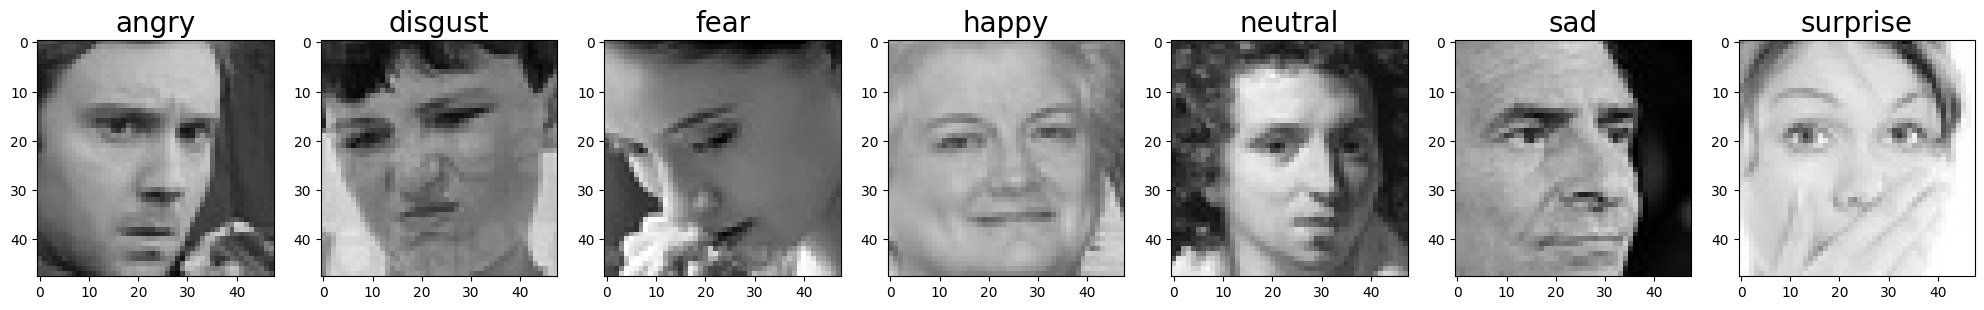

In [6]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = 'C:/Users/kowsh/Downloads/images/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL +'/'+ directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

**Explanation:** Show how the images in the data set look like.

In [7]:
img_shape = 48
batch_size = 64
train_data_path = 'C:/Users/kowsh/Downloads/images/train/'
test_data_path = 'C:/Users/kowsh/Downloads/images/validation/'

In [8]:
#using data generators to generate batches of images 
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
     validation_split=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )
val_preprocessor=ImageDataGenerator(rescale=1./255.,
                              validation_split=0.2)
test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)
train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)
validation_data = val_preprocessor.flow_from_directory(
    train_data_path,
    subset="validation",
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
)
test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### **CNN Model**

In [9]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    return model

In [10]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                      

### **Specifying CNN Callbacks**

In [11]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = validation_data.n // validation_data.batch_size

### **CNN Training**

In [12]:
CNN_history = CNN_Model.fit( train_data , validation_data= validation_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50


360/360 [==============================] - 344s 932ms/step - loss: 2.0886 - accuracy: 0.1996 - val_loss: 1.9921 - val_accuracy: 0.2486 - lr: 0.0010
Epoch 2/50
360/360 [==============================] - 289s 802ms/step - loss: 1.8239 - accuracy: 0.2549 - val_loss: 1.7727 - val_accuracy: 0.3045 - lr: 0.0010
Epoch 3/50
360/360 [==============================] - 231s 642ms/step - loss: 1.7025 - accuracy: 0.3113 - val_loss: 1.9730 - val_accuracy: 0.2885 - lr: 0.0010
Epoch 4/50
360/360 [==============================] - 193s 537ms/step - loss: 1.6053 - accuracy: 0.3642 - val_loss: 1.4631 - val_accuracy: 0.4316 - lr: 0.0010
Epoch 5/50
360/360 [==============================] - 187s 520ms/step - loss: 1.4995 - accuracy: 0.4143 - val_loss: 1.3702 - val_accuracy: 0.4766 - lr: 0.0010
Epoch 6/50
360/360 [==============================] - 190s 527ms/step - loss: 1.4287 - accuracy: 0.4540 - val_loss: 1.5616 - val_accuracy: 0.3915 - lr: 0.0010
Epoch 7/50
360/360 [========================

In [14]:
pd.DataFrame(CNN_history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,2.088598,0.199600,1.992100,0.248611,1.000000e-03
1,1.823886,0.254914,1.772725,0.304514,1.000000e-03
2,1.702463,0.311272,1.973042,0.288542,1.000000e-03
3,1.605324,0.364150,1.463060,0.431597,1.000000e-03
4,1.499517,0.414289,1.370152,0.476562,1.000000e-03
5,1.428728,0.454035,1.561621,0.391493,1.000000e-03
6,1.371909,0.479257,1.343385,0.485764,1.000000e-03
7,1.337915,0.492390,1.356298,0.466667,1.000000e-03
8,1.294399,0.512741,1.291146,0.509549,1.000000e-03
9,1.276986,0.522352,1.192476,0.546181,1.000000e-03


In [17]:
CNN_Model.save_weights('face_emotion_model.h5')

### **Visualising CNN Loss and Accuracy**

In [18]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

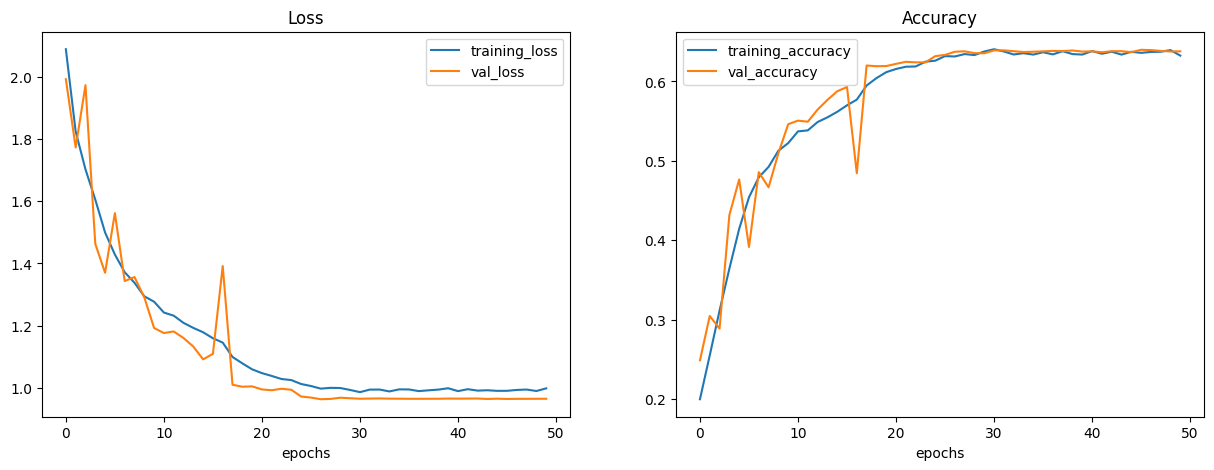

In [19]:
plot_curves(CNN_history)

### **Evaluating CNN Model**

In [22]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

111/111 [==============================] - 13s 116ms/step - loss: 0.9549 - accuracy: 0.6458
    Test Loss: 0.95486
Test Accuracy: 64.58%


###   **NN Confusion Matrix**

In [25]:
CNN_Predictions = CNN_Model.predict(test_data)

CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

111/111 [==============================] - 12s 111ms/step


In [26]:

test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

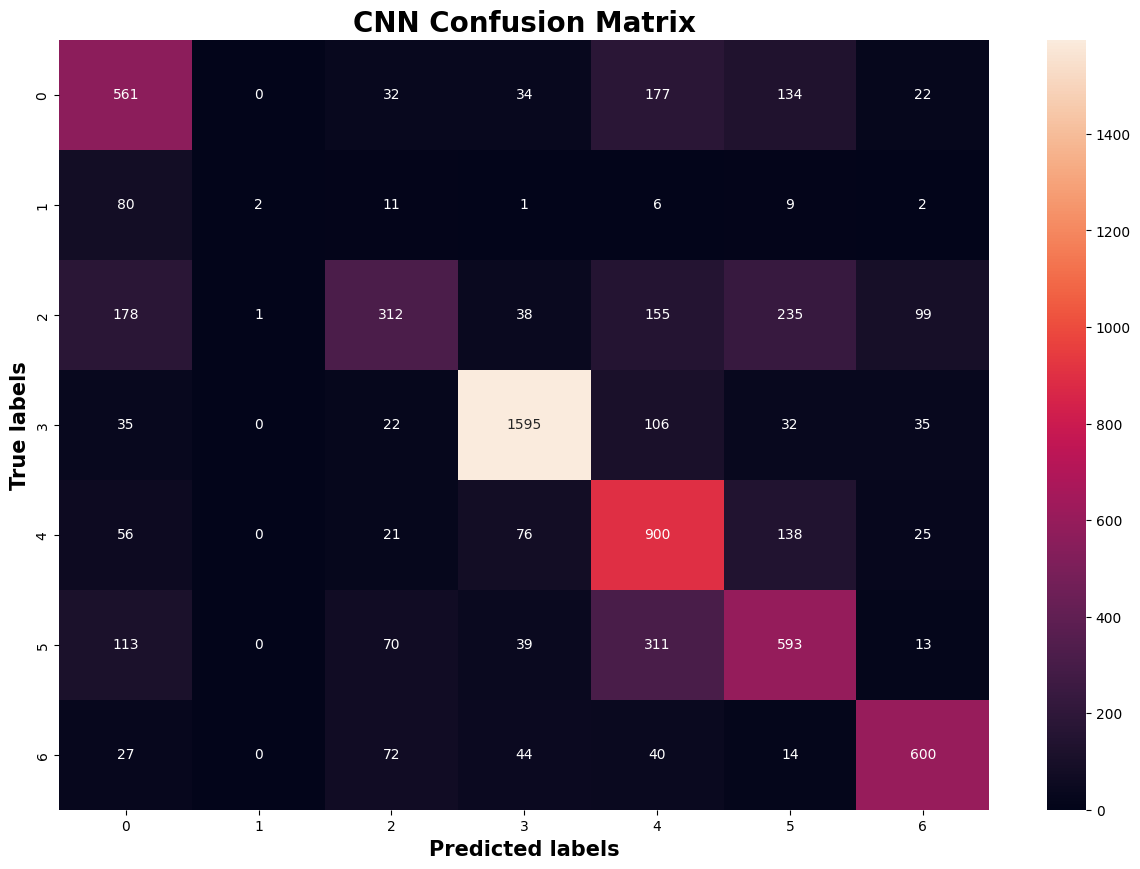

In [28]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix,classification_report,f1_score

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

In [29]:
print(cm)

[[ 561    0   32   34  177  134   22]
 [  80    2   11    1    6    9    2]
 [ 178    1  312   38  155  235   99]
 [  35    0   22 1595  106   32   35]
 [  56    0   21   76  900  138   25]
 [ 113    0   70   39  311  593   13]
 [  27    0   72   44   40   14  600]]


In [30]:
cr=classification_report(test_data.labels, CNN_Predictions)

In [31]:
print(cr)

              precision    recall  f1-score   support

           0       0.53      0.58      0.56       960
           1       0.67      0.02      0.04       111
           2       0.58      0.31      0.40      1018
           3       0.87      0.87      0.87      1825
           4       0.53      0.74      0.62      1216
           5       0.51      0.52      0.52      1139
           6       0.75      0.75      0.75       797

    accuracy                           0.65      7066
   macro avg       0.64      0.54      0.54      7066
weighted avg       0.65      0.65      0.63      7066



In [34]:
f1_score(test_data.labels,CNN_Predictions,average='weighted')

0.634414345244489